# Install and Import Dependencies


In [1]:
#import libraries
import pandas as pd
import numpy as np
import warnings;
warnings.simplefilter("ignore")
from fbprophet import Prophet
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from datetime import datetime

Importing plotly failed. Interactive plots will not work.


# Read in Data and Process Data

In [31]:
# download Data
df = pd.read_excel("Case_License_Volume_2021-09-17_11-46-43.xlsx", sheet_name="Data")

# set dtypes
df["Period"] = pd.to_datetime(df.Period)


# df = df[df.Period != "2021-08-01"]
#in case the dates are seperated we can merge them together with the lower mentioned function:
#pd.DatetimeIndex(df[" "] +"-"+df[" "])

df = df.dropna(how="any")


In [32]:
df

,Application Group,Case Complexity,Period,Application,Standard Case Equivalent,Case Count Country Factor,Case Count
0,ACESFW,BASIC,2021-08-01,ACESFW,17.25,69.0,88
1,Appropriation Request,BASIC,2021-08-01,WIPS,6.75,27.0,27
2,CCMT,CUSTOM,2021-08-01,CashColAU,4600.40,4600.4,5784
3,CCMT,CUSTOM,2021-08-01,CashColBR,45181.80,45181.8,56624
4,CCMT,CUSTOM,2021-08-01,CashColCA,23013.00,23013.0,27841
...,...,...,...,...,...,...,...
1252,SDT,STANDARD,2020-10-01,SDT,575.20,575.2,675
1253,SFSCredit,BASIC,2020-10-01,SFSCredit,15.85,63.4,67
1254,Sonderlieferschein,BASIC,2020-10-01,Sonderli,103.00,412.0,412
1255,TOPS,BASIC,2020-10-01,GrafixWork,396.45,1585.8,1881


### Case Count Prediction

#### Data Preparations

In [33]:
#lets rename the columns for the Prophet. In this case we call case count as y
df.rename(columns= {"Period": "ds", "Standard Case Equivalent": "y"}, inplace= True )

#we group the AG and Period as a sum to get the distinctive variables and avoid duplicates.
#here we create grouped Date Frame with out any index, in order to manipulate with AG and period later on.
df = df.groupby(["Application Group", "ds",], as_index = False).sum()

#to assign application groups to certain index we group them by App Gr.
df["Index"] = df.groupby(["Application Group"]).ngroup()


df.to_excel("Data.xlsx")

In [35]:
df.head(50)

,Application Group,ds,y,Case Count Country Factor,Case Count,Index
0,ACESFW,2021-01-01,0.95,3.8,4,0
1,ACESFW,2021-02-01,13.45,53.8,61,0
2,ACESFW,2021-03-01,6.60,26.4,27,0
3,ACESFW,2021-04-01,5.40,21.6,26,0
4,ACESFW,2021-05-01,3.20,12.8,16,0
5,ACESFW,2021-06-01,10.75,43.0,53,0
6,ACESFW,2021-07-01,19.35,77.4,101,0
7,ACESFW,2021-08-01,17.25,69.0,88,0
8,Appropriation Request,2020-10-01,9.75,39.0,39,1
9,Appropriation Request,2020-11-01,10.25,41.0,41,1


In [28]:
df.tail(50)

,Application Group,ds,y,Case Count Country Factor,Case Count,Index
187,SITAR,2021-06-01,441.00,441.0,551,18
188,SITAR,2021-07-01,16.60,16.6,21,18
189,SITAR,2021-08-01,443.00,443.0,554,18
190,SUBSEA,2020-11-01,1816.40,1816.4,2261,19
191,SUBSEA,2020-12-01,88.00,88.0,88,19
192,SUBSEA,2021-01-01,178.00,178.0,178,19
193,SUBSEA,2021-02-01,126.00,126.0,126,19
194,SUBSEA,2021-03-01,512.60,512.6,536,19
195,SUBSEA,2021-04-01,824.20,824.2,834,19
196,SUBSEA,2021-05-01,778.80,778.8,785,19


In [45]:
lst = []
for i in range(0, 24):
    filt = df["Index"] == i
    model = df.loc[filt,["ds", "y"]]
    m = [len(model)]
    lst = lst + m
print("Maximum of Datapoints:", max(lst),"\nApplication Name:", df.loc[filt,["Application Group"]].iloc[0,0], 
      "\nApplication Number:", i)

Maximum of Datapoints: 11 
Application Name: UOM 
Application Number: 23


## Programm that runs through the multiple time series and makes a prediction

In [29]:
from functools import reduce
def Iterate(df):
    dfs = []
    for n in range(0, 24): # define how many applications you have

        #create data frame
        filt = df["Index"] == n

        model = "({0},{1})".format("model", n) 
        model = df.loc[filt,["ds", "y"]]

        #create fit
        try:
            m = "({0},{1})".format("m", n) 
            m = Prophet(interval_width=0.95, daily_seasonality = True)
            model = m.fit(model)

        except ValueError:
            continue

        #create forecast
        future = "({0},{1})".format("future", n)
#         future = m.make_future_dataframe(periods=8, freq='M')
        future = pd.date_range("2021-09-01",  freq = "MS", periods = 1) #how many months to forecast
        future = pd.DataFrame(future)
        future.columns = ["ds"]
        future["ds"] = pd.to_datetime(future["ds"])

        forecast = "({0},{1})".format("forecast", n)
        forecast = m.predict(future)
        forecast = forecast[["ds", "yhat"]]
        model = df.loc[filt,["ds", "y"]]
        model.columns = forecast.columns
        model = pd.concat([model, forecast], axis=0)
        
        # merge together the results
        dfs.append(model)
        
    
        
        

    #merge on one column
#     df_final = reduce(lambda how: pd.merge(how='outer'), dfs)
    df_final = reduce(lambda left,right: pd.merge(left,right,how="outer"), dfs)
    #pull out excel file and make a dashboard in excel
    df_final.to_excel("Results.xlsx")
    return df_final
df_final = Iterate(df)    


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 5.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality.

In [46]:
df_final.head(50)

,ds,yhat
0,2021-01-01,0.950000
1,2021-02-01,13.450000
2,2021-03-01,6.600000
3,2021-04-01,5.400000
4,2021-05-01,3.200000
5,2021-06-01,10.750000
6,2021-07-01,19.350000
7,2021-08-01,17.250000
8,2021-09-01,17.974084
9,2020-10-01,9.750000


#### model_0 

After Data Preperations we can built first model for the 1st Application

In [40]:
#our filter is App Gr "ACESFW" which has index 0
filt = df["Index"] == 0
model_0 = df.loc[filt,["ds", "y"]]
model_0


,ds,y
0,2021-01-01,0.95
1,2021-02-01,13.45
2,2021-03-01,6.60
3,2021-04-01,5.40
4,2021-05-01,3.20
5,2021-06-01,10.75
6,2021-07-01,19.35
7,2021-08-01,17.25


# Train Model

#### train_model_0

In [41]:
#building Ml Model - PROPHET


m = Prophet(interval_width=0.95, daily_seasonality= True)
m.fit(model_0)
#red sign indicates that there are too little variables

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 5.


# Forecast Away

<AxesSubplot:>

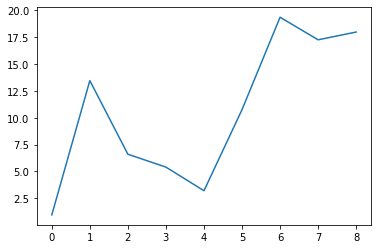

In [42]:

# future0 = m.make_future_dataframe(periods=5, freq='M')
future0 = pd.date_range("2021-09-01",  freq = "MS", periods = 1) # how long you want the forecast
future0 = pd.DataFrame(future0)
future0.columns = ["ds"]
future0["ds"] = pd.to_datetime(future0["ds"])
forecast0 = m.predict(future0)

forecast0[["ds", "yhat"]]
forecast = forecast0[["ds", "yhat"]]
# plt.plot(forecast0["yhat"])
# plt.plot(model_0["y"])
s = pd.DataFrame(np.concatenate((model_0, forecast),axis =0 ))

s.columns = [ 'ds', "y"]
s
s["y"].plot()

In [157]:
#append
# s = pd.DataFrame(np.concatenate((model_0, forecast),axis =0 ))
# s.columns = [ 'ds', "y"]
# s

,ds,y
0,2020-12-01,0.5
1,2021-01-01,1.7
2,2021-02-01,14.8
3,2021-03-01,6.1
4,2021-04-01,6.65
5,2021-05-01,5.05
6,2021-06-01,13.15
7,2021-07-01,23.0
8,2021-08-01,18.828211
9,2021-09-01,21.094184


In [297]:
model_0.columns = forecast.columns
model = pd.concat([model_0, forecast, ], axis = 0)
model = model.squeeze()
type(model)


pandas.core.frame.DataFrame

### train_model_1

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


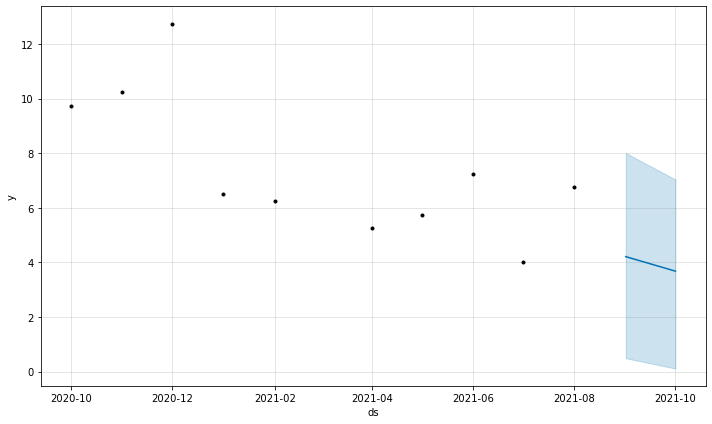

In [44]:
filt1 = df["Index"] == 1
model_1 = df.loc[filt1,["ds", "y"]]

m1 = Prophet(interval_width=0.95, weekly_seasonality=False)
model1 = m1.fit(model_1)
# future1 = m1.make_future_dataframe(periods=13, freq='M')
future1 = pd.date_range("2021-09-01",  freq = "MS", periods = 2)
future1 = pd.DataFrame(future1)
future1.columns = ["ds"]
future1["ds"] = pd.to_datetime(future1["ds"])
forecast1 = m.predict(future1)
forecast1 = m1.predict(future1)
m1.plot(forecast1)
forecast1  = forecast1[["ds", "yhat"]]


### train_model_2

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


,ds,yhat
0,2020-10-01,770968.128008
1,2020-11-01,735417.620307
2,2020-12-01,701013.903294
3,2021-01-01,665463.395480
4,2021-02-01,629912.887411
5,2021-03-01,597802.751042
6,2021-04-01,562252.242735
7,2021-05-01,527848.525172
8,2021-06-01,492298.123496
9,2021-07-01,457894.508971


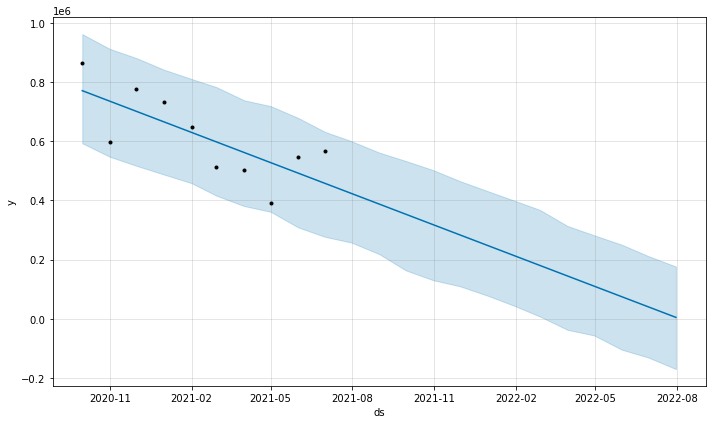

In [54]:
filt2 = df["Index"] == 2
model_2 = df.loc[filt2,["ds", "y"]]

result = adfuller(model_2["y"])



m2 = Prophet(interval_width=0.95, weekly_seasonality=False)
model2 = m2.fit(model_2)
future2 = m2.make_future_dataframe(periods=13, freq='M')
forecast2 = m2.predict(future2)
m2.plot(forecast2)
forecast2[["ds", "yhat"]]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 7.


,ds,yhat
0,2020-10-01,4.153678
1,2020-11-01,3.751380
2,2020-12-01,2.838782
3,2021-01-01,2.700842
4,2021-02-01,3.661242
5,2021-03-01,3.687749
6,2021-04-01,4.325978
7,2021-05-01,4.044989
8,2021-06-01,3.011082
9,2021-07-01,4.412127


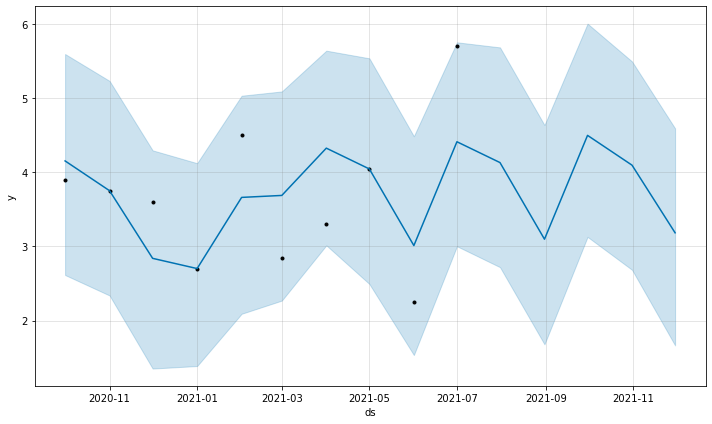

In [28]:
filt3 = df["Index"] == 3
model_3 = df.loc[filt3,["ds", "y"]]
m3 = Prophet(interval_width=0.95, weekly_seasonality=True)
model3 = m3.fit(model_3)
future3 = m3.make_future_dataframe(periods=5, freq='M')
forecast3 = m3.predict(future3)

m3.plot(forecast3)
forecast3[["ds", "yhat"]]

In [ ]:
#pull out excel file and make a dashboard in excel
df_final.to_excel("Results.xlsx")